## Molecule odor prediction via GINs with self-supervised contrastive pretraining
*Stanford CS224W project by Sarah Chen, Matthew Ding, and Cathy Zhou*

- Before running the notebook, change the Colab runtime type to use a GPU


In [1]:
# toggle whether or not to use pretraining
use_pretraining = False

### Installations

We install various dependencies.

In [2]:
import torch
print("PyTorch has version {}".format(torch.__version__))

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install pyrfume
!pip install torch-ema

PyTorch has version 1.13.1+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 10.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 7.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-bki6shkf
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-bki6shkf
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit c78f358bb664a15650c68113f7108be89aca98da
  Installing build depend

Load files with helpful modules from GitHub

In [3]:
!git clone https://github.com/paridhimaheshwari2708/GraphSSL.git
!git clone https://github.com/mattyding/cs224w-project.git


Cloning into 'GraphSSL'...
remote: Enumerating objects: 187, done.
remote: Total 187 (delta 0), reused 0 (delta 0), pack-reused 187
Receiving objects: 100% (187/187), 54.62 KiB | 1.11 MiB/s, done.
Resolving deltas: 100% (112/112), done.
Cloning into 'cs224w-project'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 143 (delta 80), reused 70 (delta 28), pack-reused 0
Receiving objects: 100% (143/143), 153.93 KiB | 2.85 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [4]:
import torch_geometric
torch_geometric.__version__

'2.3.0'

In [5]:
import numpy as np

from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score, roc_auc_score
from tqdm import tqdm


import sys
sys.path.append('/content/cs224w-project/GNNose')
sys.path.append("/content/GraphSSL/")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Set random seeds so that results can be reproduced. Note PyG has an [issue with reproducibility](https://github.com/pyg-team/pytorch_geometric/issues/92) when using GPUs.

In [6]:
seed = 12345

torch_geometric.seed.seed_everything(seed)

### Load the Leffingwell odor dataset

Within `get_graph_data`, we add initial node features calculated by using atom features and pooling features from adjacent edges.

In [7]:
# load and split the dataset 
from odor_data import get_graph_data

graph_list = get_graph_data('lw') # 'ol' for Dream Olfaction dataset

Observe an example graph in PyG format:

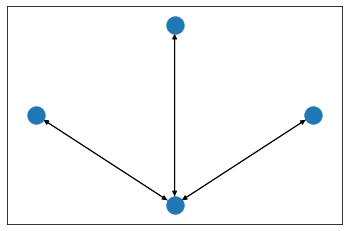

In [8]:
from plot_utils import nx_draw_molecule
nx_draw_molecule(graph_list[0].x, graph_list[0].edge_index)

We use a 70%, 10%, 20% train-val-test split

In [9]:
train_set, val_set, test_set = torch.utils.data.random_split(graph_list, [0.7, 0.1, 0.2])

batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)

### Choose model architecture hyperparameters

In [10]:
hidden_channels = 64
num_layers = 1
dropout_p = 0
pooling_type = 'max'

### Load the model

We define the `ScentClassifier` model in `odor_model`, which is a GIN with a max-pooling layer and classifier head.

In [11]:
# set hyperparameters
in_channels = list(graph_list[2].x.shape)[-1]
out_channels = 1 

### Apply pretraining

In [12]:
from plot_utils import plot_losses, plot_loss

In [13]:
if use_pretraining:
    from odor_pretrain import build_pretraining_loader, pretrain
    from odor_model import PretrainingGIN
    
    pretrain_epochs = 30
    # pretrain_batch_size = 256
    pretrain_lr = 1e-3
    pretrain_weight_decay = 1e-5

    # We apply this approach using the GraphSSL GitHub repository.
    pretrain_train_loader = build_pretraining_loader(train_set, "train", batch_size=batch_size)
    pretrain_val_loader = build_pretraining_loader(val_set, "val", batch_size=batch_size)


In [14]:
# apply pretraining 
if use_pretraining:
    pretrain_model = PretrainingGIN(
        in_channels, 
        hidden_channels, 
        num_layers, 
        out_channels,
        dropout=dropout_p
    ).to(device)

    pretrain_optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=pretrain_lr, weight_decay=pretrain_weight_decay)

    val_losses = []
    train_losses = []
    for epoch in (range(pretrain_epochs)):
        train_loss = pretrain(pretrain_model, pretrain_optimizer, epoch, "train", pretrain_train_loader, device)
        val_loss = pretrain(pretrain_model, pretrain_optimizer, epoch, "val", pretrain_val_loader, device)
        log = "Epoch {}, Train Loss: {:.3f}, Val Loss: {:.3f}"
        print(log.format(epoch, train_loss, val_loss))

        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    plot_losses(train_losses, val_losses, "pretraining loss")

### Fine-tune on labeled data

In [15]:
num_epochs = 50
lr = 1e-4
weight_decay = 1e-6

In [16]:
# initialize model and finetune 
from odor_model import ScentClassifier
from odor_train import train, test
from torch_ema import ExponentialMovingAverage

def run_finetuning(model, device, num_epochs, lr, weight_decay):
    """Train or finetune the given model using the train/val sets"""

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    ema = ExponentialMovingAverage(model.parameters(), decay=0.995)

    # track metrics
    roc_scores, f1_scores, accs, losses, val_losses = [], [], [], [], []

    for epoch in tqdm(range(num_epochs)):
        loss = train(model, optimizer, train_loader, 'train', device, weighted_BCE=True, ema=ema)
        val_loss = train(model, optimizer, val_loader, 'val', device, weighted_BCE=True)
        train_acc, train_preds, train_true  = test(model, train_loader, device)
        test_acc, test_preds, test_true = test(model, val_loader, device)

        # calculate bootstrapped ROC AUC score over entire val set
        _, whole_val_preds, whole_val_true = test(
            model, DataLoader(val_set, batch_size=len(val_set), shuffle=True), device)
        whole_val_preds = whole_val_preds.squeeze()
        whole_val_true = whole_val_true.squeeze()
        rocauc_score = roc_auc_score(whole_val_true.cpu(), whole_val_preds.cpu())
        f1 = f1_score(whole_val_true.cpu(), whole_val_preds.cpu())

        # track metrics
        roc_scores.append(rocauc_score)
        f1_scores.append(f1)
        accs.append(test_acc)
        losses.append(loss)
        val_losses.append(val_loss)

    best_f1_score = max(f1_scores)
    best_f1_epoch = f1_scores.index(best_f1_score)
    best_auc_score = max(roc_scores)
    best_auc_epoch = roc_scores.index(best_auc_score)

    plot_losses(losses, val_losses, title='finetuning: train vs. val loss')
    fig, ax = plt.subplots(1, 2, figsize=(6, 2))
    for i, (name, metric) in enumerate([
        ('f1', f1_scores), ('roc', roc_scores)
    ]):
        ax[i].plot(range(len(metric)), metric)
        ax[i].set_ylim((0, 1))
        ax[i].set_title(name)
    plt.show()
    
    return best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


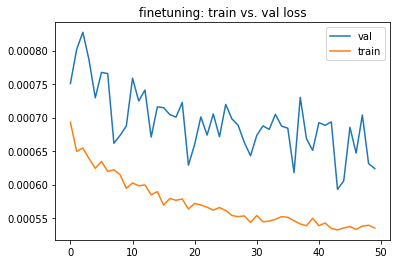

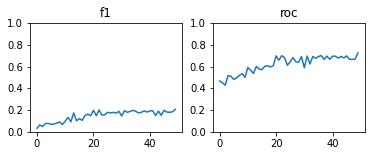

100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


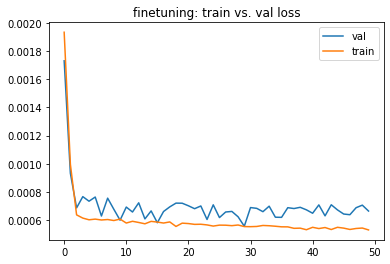

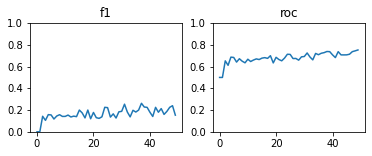

100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


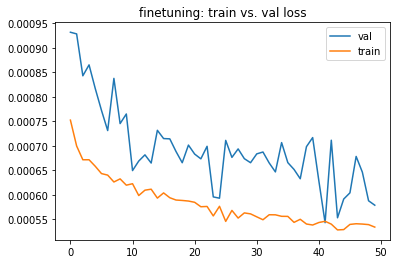

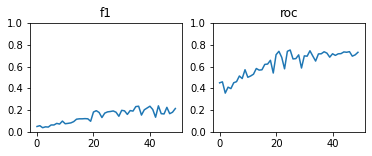

In [17]:
num_trials = 3
dropout_p = 0
trial_results = []

for t in range(num_trials):
    model = ScentClassifier(
        in_channels,
        hidden_channels, 
        num_layers, 
        out_channels,
        dropout=dropout_p,
        pooling_type=pooling_type,
    )
    model = model.to(device)

    if use_pretraining:
        model.gnn.load_state_dict(
            pretrain_model.gnn.state_dict()
        )

    best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch = run_finetuning(model, device, num_epochs, lr, weight_decay)
    trial_results.append((best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch))

In [18]:
trial_results

[(0.20689655172413793, 49, 0.7267540152155536, 49),
 (0.2622950819672131, 37, 0.7527472527472526, 49),
 (0.23880597014925373, 43, 0.7523245984784446, 25)]

### Hyperparameter tuning (optional)

We can also perform a gridsearch to find optimal values for various hyperparameters.

In [19]:
hyperparam_tuning = False

In [20]:
if hyperparam_tuning:
    import itertools 

    param_search = {
        "lr": [1e-2, 5e-3, 1e-3],
        "weight_decay": [1e-5, 1e-6],
    }

    param_search_results = []

    for lr, weight_decay in list(itertools.product(*list(param_search.values()))):
        # create model
        model = ScentClassifier(
            in_channels,
            hidden_channels, 
            num_layers, 
            out_channels,
            dropout=dropout_p,
            pooling_type=pooling_type,
        )
        model = model.to(device)

        # load pretrained weights, if relevant
        if use_pretraining:
            model.gnn.load_state_dict(
                pretrain_model.gnn.state_dict()
            )

        # train
        best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch = run_finetuning(
            model, device, num_epochs, lr, weight_decay)

        param_search_results.append(
            ((best_f1_score, best_f1_epoch, best_auc_score, best_auc_epoch), (lr, weight_decay))
        )


In [21]:
if hyperparam_tuning:
    # show best results, by F1 or AUC
    param_search_results.sort(key = lambda x: x[0][0])
    print("Best F1 score:", param_search_results[-1][0][0])
    print("Best F1 epoch:", param_search_results[-1][0][1])
    print(
        "Best F1 params:", 
        dict(zip(
            param_search.keys(),
            param_search_results[-1][-1]        
        ))
    )

    param_search_results.sort(key = lambda x: x[0][2])
    print("Best AUC score:", param_search_results[-1][0][2])
    print("Best AUC epoch:", param_search_results[-1][0][3])
    print(
        "Best AUC params:", 
        dict(zip(
            param_search.keys(),
            param_search_results[-1][-1]        
        ))
    )

### Visualize model embeddings

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_embeddings(model, graph_list, title=None, savepath=None):
    """Visualize model embeddings for graphs in graph_list via PCA and t-SNE."""
    # look just at GNN + pooling
    emb_model = PretrainingGIN(
        in_channels, 
        hidden_channels, 
        num_layers, 
        out_channels,
        dropout=dropout_p
    ).to(device)

    if model is not None:
        print('loading state dict')
        emb_model.gnn.load_state_dict(
            model.gnn.state_dict()
        )

    # generate embeddings
    coords = []
    labels = []
    for graph_data in graph_list:
        graph_data = graph_data.to(device)
        readout = emb_model(graph_data.x, graph_data.edge_index, batch=torch.tensor([0]).to(device))
        coords.append(readout.squeeze().cpu())
        labels.append(graph_data.y.item())

    X = torch.vstack(coords).detach().numpy()

    pca = PCA(n_components=30)
    X_pca = pca.fit_transform(X)

    X_embedded = TSNE(n_components=2).fit_transform(X_pca)

    labels = np.array(labels)

    plt.scatter(X_embedded[(labels==0), 0], X_embedded[(labels==0), 1], c='red', s=0.2, label='not pungent')
    plt.scatter(X_embedded[(labels==1), 0], X_embedded[(labels==1), 1], c='blue', s=0.2, label='pungent')
    plt.legend()
    # plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=['red' if x else 'blue' for x in labels], s=0.2)
    if title:
        plt.title(title)

    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()
    # visualize 

In [23]:
if use_pretraining:
  plot_embeddings(None, graph_list, 
                  title='t-SNE embedding visualization: before training', 
                  savepath=None)
  plot_embeddings(model, graph_list, 
                  title='t-SNE embedding visualization: after training',
                  savepath=None)

### Explainability: Feature Importance

In [24]:
import random
from rdkit import Chem

from torch_geometric import explain
from torch_geometric.explain import Explanation, Explainer, ModelConfig

In [25]:
# Explainer for node attributes
# Node mask: individual atrributes (features)
  # edge features are integrated into node freatures previously
# Edge mask: for each edge object
na_explainer = Explainer(
    model, 
    algorithm=explain.algorithm.GNNExplainer(),
    explanation_type="model", 
    model_config=ModelConfig(mode="binary_classification", task_level="graph", return_type="probs"),
    node_mask_type="attributes",
    edge_mask_type="object"
)

In [26]:
# get explanations on the test set
all_na_explanations = []
for graph_idx in range(len(test_set)):
  data = test_set[graph_idx]
  x, edge_index = data.x, data.edge_index
  na_explanation = na_explainer(x.to(device), edge_index.to(device), batch=torch.tensor([0]).to(device))
  all_na_explanations.append(na_explanation)

In [27]:
# Get the mean of node attribtute importance across all graphs
NODE_FEATURE_NUM = 9
na_importance = torch.mean(torch.stack([torch.mean(e.node_mask, axis=0) for e in all_na_explanations]), axis=0)

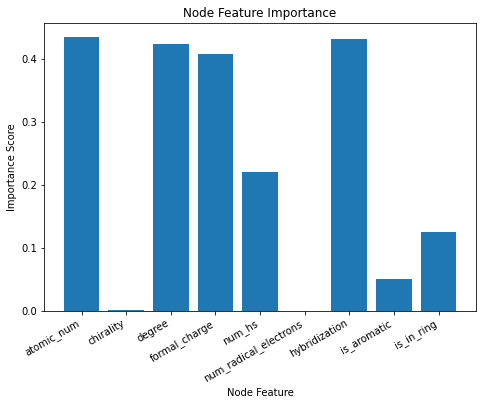

In [28]:
# Plot node feature importance
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['atomic_num', 'chirality', 'degree', 'formal_charge', 'num_hs', 'num_radical_electrons', 'hybridization', 'is_aromatic', 'is_in_ring']
ax.bar(features, list(na_importance.cpu())[:9])

plt.title("Node Feature Importance")
plt.xlabel("Node Feature")
plt.ylabel("Importance Score")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

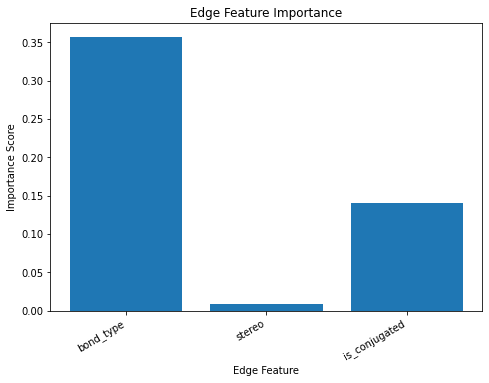

In [29]:
# Plot edge feature importance
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features = ['bond_type', 'stereo', 'is_conjugated']
ax.bar(features, list(na_importance.cpu())[9:])

plt.title("Edge Feature Importance")
plt.xlabel("Edge Feature")
plt.ylabel("Importance Score")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

### Explainability: Structural Importance

In [30]:
# Explainer for edge structure
# Node mask: for each node object
# Edge mask: for each edge object
ob_explainer = Explainer(
    model, 
    algorithm=explain.algorithm.GNNExplainer(),
    explanation_type="model", 
    model_config=ModelConfig(mode="binary_classification", task_level="graph", return_type="probs"),
    node_mask_type="object",
    edge_mask_type="object"
)

In [31]:
# get explanations for all of test set
all_ob_explanations = []
for graph_idx in range(len(test_set)):
  data = test_set[graph_idx]
  x, edge_index = data.x, data.edge_index
  ob_explanation = ob_explainer(x.to(device), edge_index.to(device), batch=torch.tensor([0]).to(device))
  all_ob_explanations.append(ob_explanation)

In [32]:
# Visualization
from pickle import NONE
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from matplotlib import colors
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

# Assign colors to nodes with higher than average scores
def atom_col(atom_imp):
  col = {}
  threshold = torch.mean(atom_imp)
  for i, imp in enumerate(atom_imp):
    if imp > threshold:
      col[i] = colors.to_rgb("#1BBC9B")
    else:
      col[i] = colors.to_rgb('#D3D3D3')
  return col
    
# Assign colors to edges with higher than average scores
def bond_col(mol, bond_imp, edge_id, threshold=0.5):
  col = {}
  threshold = sum(bond_imp) / len(bond_imp)
  for idx, bond in enumerate(mol.GetBonds()):
      i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
      i, j = min(i, j), max(i, j)
      imp = bond_imp[edge_id.index((i, j))]
      if imp > threshold:
        col[i] = colors.to_rgb("#F06060")
      else:
        col[i] = colors.to_rgb('#D3D3D3')
  return col

# Generate visualization for an atom
def visualize_molecule_explanation(dataset, graph_idx):
  data = dataset[graph_idx]
  x, edge_index = data.x, data.edge_index
  ob_explanation = ob_explainer(x.to(device), edge_index.to(device), batch=torch.tensor([0]).to(device))
  atom_imp = ob_explanation.node_mask
  bond_imp = []
  edge_idx = []
  # average the two "directional" edges for score of undirected edge
  for i in range(len(ob_explanation.edge_mask)):
    a, b = ob_explanation.edge_index[0][i].cpu(), ob_explanation.edge_index[1][i].cpu()
    if a < b:
      edge_idx.append((a, b))
      temp = NONE
      for i in range(len(edge_index[0])):
        if edge_index[0][i].item() == b.item() and edge_index[1][i].item() == a.item():
          temp = i
          break
      bond_imp.append((ob_explanation.edge_mask[i]+ob_explanation.edge_mask[temp])/2)
  mol = Chem.MolFromSmiles(data.smiles)
  cp = Chem.Mol(mol)
  # generate colors according to importance scores
  highlightAtomColors = atom_col(atom_imp)
  highlightAtoms = list(highlightAtomColors.keys())
  highlightBondColors = bond_col(mol, bond_imp, edge_idx)
  highlightBonds = list(highlightBondColors.keys())

  # draw image
  image_width, image_height = 400, 200
  rdDepictor.Compute2DCoords(cp, canonOrient=True)
  drawer = rdMolDraw2D.MolDraw2DCairo(image_width, image_height)
  drawer.drawOptions().useBWAtomPalette()
  drawer.DrawMolecule(
      cp,
      highlightAtoms=highlightAtoms,
      highlightAtomColors=highlightAtomColors,
      highlightBonds=highlightBonds,
      highlightBondColors=highlightBondColors,
  )
  drawer.FinishDrawing()
  drawer.WriteDrawingText(f"{graph_idx}.png")


In [33]:
# 5 random visualizations
idx = random.sample(range(len(test_set)), 5)
for i in idx:
  visualize_molecule_explanation(test_set, i)

Note: to view the visualizations, click on the "Files" tab on the left and download the respective png files.